# Brain Tumor Detection with CNN, using Keras

# Detección de tumores cerebrales con CNN, utilizando la librería Keras

Installing dependencies for image pre-processing and Dataframe creation.

Instalando dependencias para preprocesamiento de imágenes y creación de Dataframe.

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import imutils

import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Creating a new folder called "processed" to store processed images.

Creando un nuevo directorio llamado processed donde se guardarán las imágenes procesadas.

In [2]:
import os
try:
    os.rmdir('./dataset/processed/yes')
except:
    pass
try:
    os.rmdir('./dataset/processed/no')
except:
    pass
try:
    os.makedirs('./dataset/processed/yes')
except:
    pass
try:
    os.makedirs('./dataset/processed/no')
except:
    pass

A processing function that finds extreme points using countours and library cv2 to properly crop the image, followed by resizing it and converting it to grayscale, meaning it would only have one channel.

Una función de procesamiento de imagen que encuentra los puntos extremos usando la librería cv2 para poder cortar la imagen apropiadamente. Seguido de esto la reescalamos y convertimos a blanco y negro, lo que significa que solo tendrá un canal.

In [3]:
def crop_image(image):
    
    # load the image, convert it to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    
    # find contours in thresholded image, then grab the largest
    # one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    
    # determine the most extreme points along the contour
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    #crop
    image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    #resize
    image = cv2.resize(image, (150, 150))
    #grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

The load_images function reads the images in the default folder, it process them and stores them in a new folder previously created. It returns two numpy arrays containing images and labels.

La función load_images ...

In [4]:
uniq_labels=['no', 'yes']
directory="./dataset"

def load_images(directory,uniq_labels):
    images = []
    labels = []
    for idx, label in enumerate(uniq_labels):
        for file in os.listdir(directory + "/" + label):
            filepath = directory + "/" + label + "/" + file
            image = file
            img = cv2.imread(filepath)
            copy_img = crop_image(img)
            filename= './dataset/processed/'+ os.path.basename(uniq_labels[idx])+ "/" + os.path.basename(file)
            cv2.imwrite(filename,copy_img)
            images.append(image)
            labels.append(uniq_labels[idx])
    images = np.array(images)
    labels = np.array(labels)        
    return images,labels  

In [5]:
images,labels= load_images(directory,uniq_labels)

We transform the numpy arrays to panda dataframes for easier manipulation.

Transformamos los arreglos Numpy a Dataframes de Panda para poder manipularlo de manera más sencilla.

In [6]:
df=pd.DataFrame(columns=['image','class'])
for i, file in enumerate(images):
    df=df.append({'image':file,'class':labels[i]},ignore_index=True)

In [7]:
df

image class
0    1 no.jpeg    no
1    10 no.jpg    no
2    11 no.jpg    no
3    12 no.jpg    no
4    13 no.jpg    no
..         ...   ...
248    Y95.jpg   yes
249    Y96.jpg   yes
250    Y97.JPG   yes
251    Y98.JPG   yes
252    Y99.JPG   yes

[253 rows x 2 columns]

The following function is used to sample the images in the dataframe so we can visualize the differences between the original images and the new ones.

La siguiente función es usada para mostrar imagenes en el conjunto de datos para poder así visualizar las diferencias entre las imágenes originales y las nuevas.

In [8]:
def plot_images(processed, n=8):
    for label in df["class"].unique():
        # grab the first n images with the corresponding y values equal to label
        images = df.loc[df['class'] == label]
        n_images = images[:n]
        columns_n = 4
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 10))
               
        i = 1
        for idx, image in n_images.iterrows():
            plt.subplot(rows_n, columns_n, i)
            if(processed):
                plt.imshow(cv2.imread("./dataset/processed/"+ os.path.basename(n_images["class"][idx]) + "/" + os.path.basename(n_images["image"][idx])))
            else:
                plt.imshow(cv2.imread("./dataset/"+ os.path.basename(n_images["class"][idx]) + "/" + os.path.basename(n_images["image"][idx])))
                
            i += 1
        
        label_to_str = lambda label: "Yes" if label == "yes" else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

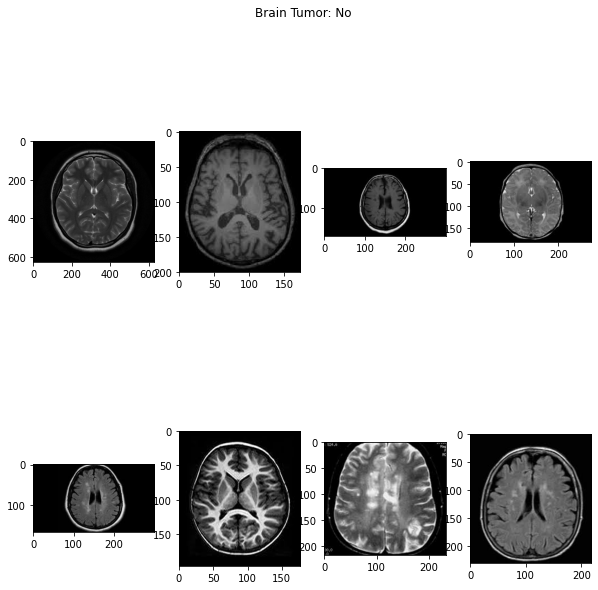

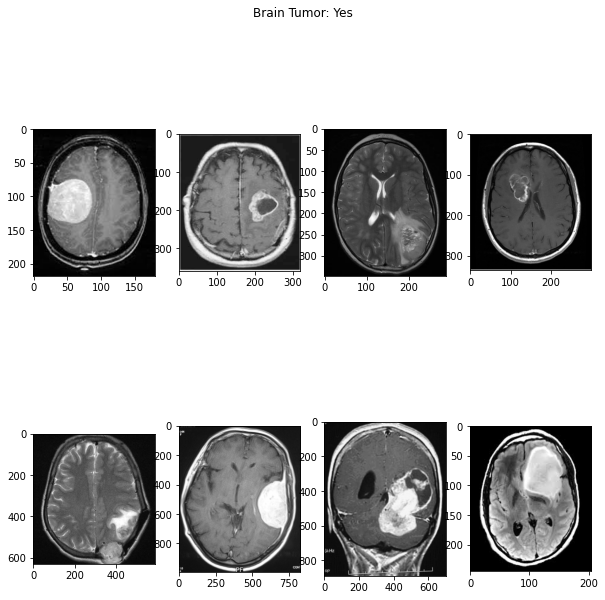

In [9]:
plot_images(False)

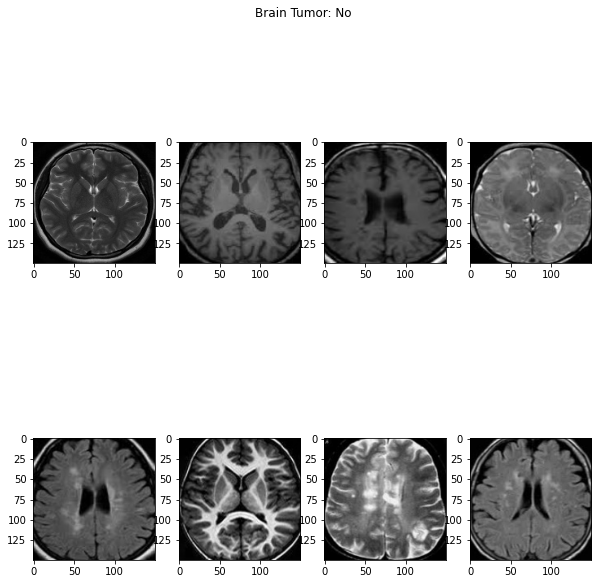

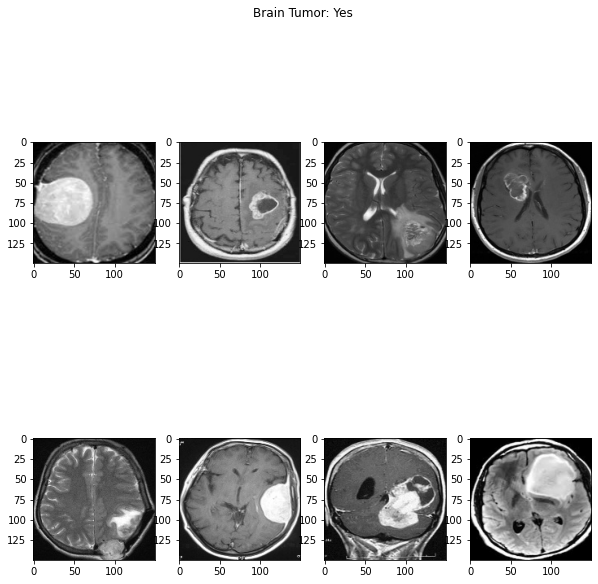

In [10]:
plot_images(True)

We apply a shuffling function to the dataframe for better performance and so it mixes the classes in the dataframe.

Aplicamos una función de shuffle (barajear en español) para mezclar en el dataframe datos con distintas clases.

In [11]:
df_shuffle = shuffle(df)
df_shuffle.reset_index(inplace=True, drop=True)

In [12]:
img_width, img_height = (150, 150)
input_shape = (img_width, img_height, 1)

Proceeding to import the tenserflow library to build our CNN model architecture.

Procedemos a importar la librería tenserflow para construir la arquitectura de nuestro modelo de Red Neuronal Convolucional.

In [13]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

We use filters with kernel sizes of (5x5) and (7x7), starting with the smallest size to initially capture more local information and later increase the size of the kernels.
After each convolution layer we add a max pooling layer with a pool size of 3x3, since we are working with images of moderate size. Subsequently, a flattening layer is used to transform the data into a vector that can go on to the next stage consisting of a multilayer perceptron.
Dropout layers are used on each hidden layer to prevent overfitting. Lastly, a dense layer with sigmoid activation, used for binary classification, produces the output.


Utilizamos filtros de tamaños medianos (5x5, 7x7), comenzando con de menor tamaño para capturar mayor información local inicialmente y posteriormente aumentar el tamaño de los filtros.
Agregamos luego de cada capa de convolución una capa de agrupación máxima con tamaño de 3x3, debido a que se trabaja con imágenes de tamaño moderado. Posteriormente se utiliza una capa de aplanamiento para transformar los datos a un vector que podrán pasar a la siguiente etapa que consiste de un perceptrón multicapa.
Se utilizan capas dropout para prevenir sobre-ajustamiento y se finaliza con una capa densa con activación sigmoide que es utilizada para clasificación binaria.

In [14]:
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(64, (7, 7), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(128, (7, 7), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 146, 146, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 64)        100416    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         401536    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0

We compile the model using binary crossentropy as the loss function, since it is the suitable option for binary classification, and Adam as the optimization algorithm.

Compilamos el modelo utilizando binary crossentropy, entropía cruzada binaria, como función de pérdida, dado que es la adecuada para clasificación binaria. Y Adam como el algoritmo de optimización.

In [16]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [17]:
for idx, image in enumerate(df_shuffle['image']):
    df_shuffle.loc[idx, "image"] = "./dataset/processed/" + os.path.basename(df_shuffle["class"][idx]) + "/" + os.path.basename(image)

In [18]:
df_shuffle

image class
0     ./dataset/processed/yes/Y62.jpg   yes
1       ./dataset/processed/no/no.jpg    no
2      ./dataset/processed/no/N15.jpg    no
3    ./dataset/processed/no/37 no.jpg    no
4    ./dataset/processed/no/42 no.jpg    no
..                                ...   ...
248   ./dataset/processed/yes/Y32.jpg   yes
249  ./dataset/processed/no/27 no.jpg    no
250   ./dataset/processed/yes/Y12.jpg   yes
251  ./dataset/processed/no/no 5.jpeg    no
252   ./dataset/processed/yes/Y26.jpg   yes

[253 rows x 2 columns]

We split the data into the training, test and validation dataframes.

Dividimos el conjunto de datos en los conjuntos de entrenamiento, prueba y validación.

In [19]:
X_train,X_=train_test_split(df_shuffle,test_size=0.2,random_state=0)

X_test,X_val=train_test_split(X_,test_size=0.2,random_state=0)

In [20]:
df_shuffle.groupby(['class']).count()

image
class       
no        98
yes      155

In [21]:
X_train.groupby(['class']).count()

image
class       
no        80
yes      122

In [22]:
X_test.groupby(['class']).count()

image
class       
no        14
yes       26

In [23]:
X_val.groupby(['class']).count()

image
class       
no         4
yes        7

In [24]:
img_generator=ImageDataGenerator(rescale=1/255)

train_data = img_generator.flow_from_dataframe(X_train, class_mode='binary',
                                            x_col="image",
                                            color_mode="grayscale",
                                            featurewise_std_normalization=True,
                                            image_size=(img_width, img_height),
                                            target_size=(img_width, img_height))
test_data = img_generator.flow_from_dataframe(X_test, class_mode='binary',
                                            x_col="image",
                                            color_mode="grayscale",
                                            image_size=(img_width, img_height),
                                            featurewise_std_normalization=True,
                                            target_size=(img_width, img_height))
val_data = img_generator.flow_from_dataframe(X_val, class_mode='binary',
                                            x_col="image",
                                            color_mode="grayscale",
                                            image_size=(img_width, img_height),
                                            featurewise_std_normalization=True,
                                            target_size=(img_width, img_height))

Found 202 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.
Found 11 validated image filenames belonging to 2 classes.


In [25]:
steps_epochs = train_data.samples / train_data.batch_size
steps_val = val_data.samples / val_data.batch_size

In [26]:
history = model.fit(x=train_data,
                    epochs=32,
                    steps_per_epoch=steps_epochs,
                    validation_data=val_data,
                    validation_steps=steps_val)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 6.3125 steps, validate for 0.34375 steps
Epoch 1/32
7/6 [=================================] - 7s 986ms/step - loss: 0.6651 - accuracy: 0.5990 - val_loss: 1.8706 - val_accuracy: 0.6364
Epoch 2/32
7/6 [=================================] - 6s 840ms/step - loss: 0.6899 - accuracy: 0.5842 - val_loss: 1.9144 - val_accuracy: 0.6364
Epoch 3/32
7/6 [=================================] - 5s 784ms/step - loss: 0.6934 - accuracy: 0.6040 - val_loss: 1.8497 - val_accuracy: 0.6364
Epoch 4/32
7/6 [=================================] - 6s 867ms/step - loss: 0.6634 - accuracy: 0.6089 - val_loss: 1.9504 - val_accuracy: 0.6364
Epoch 5/32
7/6 [=================================] - 6s 888ms/step - loss: 0.6701 - accuracy: 0.6040 - val_loss: 1.9061 - val_accuracy: 0.6364
Epoch 6/32
7/6 [=================================] - 6s 890ms/step - loss: 0.6734 - accuracy: 0.6040 - val_loss: 1.8257 - val_accuracy: 0.6364
Epoch 7/32
7/6 [=========================

Finally, we evaluate the model with the testing data obtaining a result 90% accuracy and a 0.55 test score, which is really good outcome.

Finalmente, evaluamos el modelo utilizando la data de prueba, lo que nos da como resultado un 90% de precisión y un puntaje de 0.55, lo que es un resultado positivo.

In [27]:
score, acc = model.evaluate(test_data,
                            verbose=2)
print('Test score:', score)
print('Test accuracy:', acc)

  ...
    to  
  ['...']
2/2 - 0s - loss: 0.5593 - accuracy: 0.9000
Test score: 0.5593030899763107
Test accuracy: 0.9
